In [124]:
%%capture
%pip install -r requirements.txt
%pip install nltk

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split

In [126]:
import warnings

# To ignore unecessary warnings
warnings.filterwarnings("ignore")

In [127]:
# Downloading nltk packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\ual-
[nltk_data]     laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ual-
[nltk_data]     laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\ual-
[nltk_data]     laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### **Dataset**

In [128]:
# Reading data Function
def read_csv(file_path):
    """Reading the data

    Args:
        file_path (string)

    Returns:
        pd.Dataframe
    """
    text_data = pd.read_csv(file_path, sep=",")
    return text_data

train_path = "./data/train/train.csv"
test_path = "./data/test/test.csv"

In [129]:
# Reading both train and test data
train_data = read_csv(train_path)
test_data = read_csv(test_path)

In [130]:
# Trainig Data first few records
train_data.head(3)

,ID,TEXT,LABEL
0,7850790573542594519,If you love good films don't ever buy this pei...,2
1,9392069522632994700,The 33 percent of the nations nitwits that sti...,2
2,5083704536542443514,I saw Anatomy years ago -- dubbed at a friends...,1


In [131]:
# Getting info from dataset
def explore_data(dataset):
    """Exploring the dataset using basic pandas operations

    Args:
        dataset (pd.Dataframe)
    """
    # dataset column value counts
    print(dataset['LABEL'].value_counts())
    print("===========================================")
    # dataset null values
    print(train_data.isnull().sum())
    print("===========================================")
    # dataset shape
    print(train_data.shape)
    print("===========================================")
    # dataset info
    print(train_data.info())
    print("===========================================")
    # null values
    print(f"Number of NULL rows: {dataset.isna().sum()}")

In [132]:
# Exploring Training Data
explore_data(train_data)

LABEL
0    32071
1    19276
2    18970
Name: count, dtype: int64
ID       0
TEXT     6
LABEL    0
dtype: int64
(70317, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70317 entries, 0 to 70316
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70317 non-null  uint64
 1   TEXT    70311 non-null  object
 2   LABEL   70317 non-null  int64 
dtypes: int64(1), object(1), uint64(1)
memory usage: 1.6+ MB
None
Number of NULL rows: ID       0
TEXT     6
LABEL    0
dtype: int64


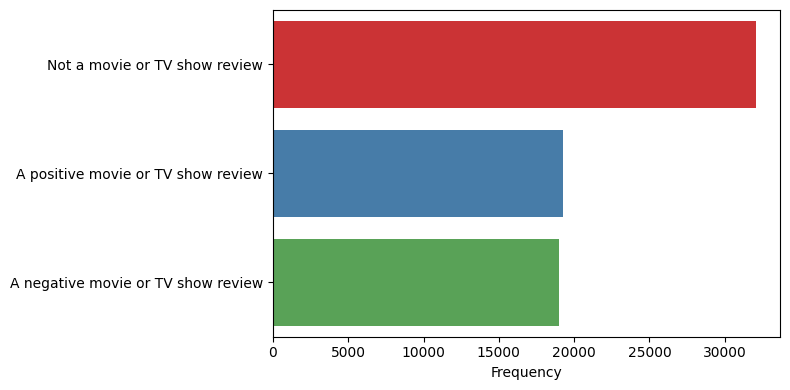

In [133]:
# Plotting the Label frequency
label_counts = train_data['LABEL'].value_counts()

plot_labels = {
    0 : 'Not a movie or TV show review',
    1 : 'A positive movie or TV show review',
    2 : 'A negative movie or TV show review'
}

label_counts.rename(index=plot_labels, inplace=True)


plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='Set1')
plt.xlabel('Frequency')
plt.ylabel('')
plt.tight_layout()
plt.show()


#### **Text Pre-processing**

In [134]:
# Function to deal with empty data in TEXT column
def transform_column(dataset):
  """Function to transform the null values and datatypes

  Args:
      dataset (pd.Dataframe)

  Returns:
      pd.Dataframe
  """
  dataset['TEXT'] = dataset['TEXT'].fillna('EMPTY REVIEW')
  dataset['TEXT'] = dataset['TEXT'].astype(str)
  return dataset

In [135]:
# Applying the function on both train and test data
train_data = transform_column(train_data)
test_data = transform_column(test_data)

In [136]:
# Preprocessing the text data by tokenizing and Lemmatizing
lemmatizer = WordNetLemmatizer()

# stop_words = set(stopwords.words('english')) - didn't help improve the model for some reason

def process_text(text):
    """Process the input text by tokenizing, lemmatizing

    Args:
        text (str): Input text to be processed

    Returns:
        str: Processed text
    """
    tokens = word_tokenize(text.lower())
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_text = " ".join(processed_tokens)
    return processed_text

train_data['TEXT'] = train_data['TEXT'].apply(process_text)

#### **Text to features**

In [137]:
# separating train and test data for features
X_train = train_data['TEXT']
y_train = train_data['LABEL']
X_test  = test_data['TEXT']

In [138]:
# Using TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### **Model Training**

In [139]:
classifier_svm = LinearSVC(class_weight="balanced", 
                           max_iter=2000, 
                           intercept_scaling=0.75,
                           verbose=2)

classifier_svm.fit(X_train_tfidf, y_train)

[LibLinear]

LinearSVC(class_weight='balanced', intercept_scaling=0.75, max_iter=2000,
          verbose=2)

In [140]:
# training data accuracy
y_train_pred = classifier_svm.predict(X_train_tfidf)
train_acc = accuracy_score(y_train, y_train_pred)

print("Training Accuracy:", train_acc)
print("======================================================")
print(classification_report(y_train, y_train_pred))

Training Accuracy: 0.9997582376950097
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32071
           1       1.00      1.00      1.00     19276
           2       1.00      1.00      1.00     18970

    accuracy                           1.00     70317
   macro avg       1.00      1.00      1.00     70317
weighted avg       1.00      1.00      1.00     70317



In [141]:
y_pred_final = classifier_svm.predict(X_test_tfidf)

submission_df = pd.DataFrame({'ID': test_data['ID'], 'LABEL': y_pred_final})
submission_df.to_csv('./data/submission/submission.csv', index=False)